# ML Final Data Preparation

## Purpose
This notebook transforms the cleaned dataset into a fully ML-ready format by encoding categorical variables, scaling numerical features, and extracting meaningful features from textual policy rules. This is the final preprocessing step before model training.

## Key Objectives
1. Load the cleaned dataset from `outputs/ml_outputs/final_ml_ready_claims.csv`
2. Encode all categorical and text fields as numeric
3. Scale and impute missing numeric features
4. Extract binary flags from textual policy rule columns
5. Save the final processed dataset as `outputs/ml_outputs/ml_model_final_ready.csv`

## Input/Output Structure
- **Input**: `outputs/ml_outputs/final_ml_ready_claims.csv`
- **Output**: `outputs/ml_outputs/ml_model_final_ready.csv`
- **Working Directory**: `notebooks-02/`

---

## Step 1: Import Required Libraries

In [42]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import json
from datetime import datetime
import re

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing tools
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    LabelEncoder, 
    OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib and Seaborn loaded for visualizations")
print(f"Scikit-learn preprocessing tools loaded")

Libraries imported successfully!
Pandas version: 2.3.2
Matplotlib and Seaborn loaded for visualizations
Scikit-learn preprocessing tools loaded


## Step 2: Define Paths and Load Dataset

In [43]:
# Define project paths
project_root = Path().resolve().parent  # Go up from notebooks-02 to project root
ml_outputs_dir = project_root / "outputs" / "ml_outputs"
input_file = ml_outputs_dir / "final_ml_ready_claims.csv"
output_file = ml_outputs_dir / "ml_model_final_ready.csv"

# Verify paths
print(f"Project root: {project_root}")
print(f"ML outputs directory: {ml_outputs_dir}")
print(f"Input file: {input_file}")
print(f"Output file: {output_file}")
print(f"\nInput file exists: {input_file.exists()}")

Project root: /Users/kxshrx/asylum/healix
ML outputs directory: /Users/kxshrx/asylum/healix/outputs/ml_outputs
Input file: /Users/kxshrx/asylum/healix/outputs/ml_outputs/final_ml_ready_claims.csv
Output file: /Users/kxshrx/asylum/healix/outputs/ml_outputs/ml_model_final_ready.csv

Input file exists: True


In [44]:
# Load the input dataset with comprehensive error handling
try:
    print(f"Loading dataset from: {input_file}")
    
    # Check if file exists and is readable
    if not input_file.exists():
        raise FileNotFoundError(f"Input file not found at {input_file}")
    
    # Check file size
    file_size = input_file.stat().st_size
    if file_size == 0:
        raise ValueError("Input file is empty")
    
    print(f"File size: {file_size / 1024**2:.2f} MB")
    
    # Load with error handling for different issues
    df = pd.read_csv(input_file)
    
    # Validate loaded data
    if df.empty:
        raise ValueError("Loaded dataset is empty")
    
    print(f"Successfully loaded dataset with shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except FileNotFoundError:
    print(f"Error: Input file not found at {input_file}")
    print("Please ensure you have run the ml_data_preparation.ipynb notebook first.")
    print(f"Expected file location: {input_file}")
    raise
    
except pd.errors.EmptyDataError:
    print("Error: The input file appears to be empty or contains no valid data.")
    raise
    
except pd.errors.ParserError as e:
    print(f"Error: Failed to parse CSV file. The file may be corrupted.")
    print(f"Parser error details: {str(e)}")
    raise
    
except UnicodeDecodeError as e:
    print(f"Error: File encoding issue. Try specifying encoding parameter.")
    print(f"Unicode error details: {str(e)}")
    # Attempt to load with different encoding
    try:
        df = pd.read_csv(input_file, encoding='latin-1')
        print("Successfully loaded with latin-1 encoding")
    except:
        raise
    
except MemoryError:
    print("Error: Not enough memory to load the dataset.")
    print("Consider using chunked reading or increasing available memory.")
    raise
    
except Exception as e:
    print(f"Unexpected error loading data: {str(e)}")
    print(f"Error type: {type(e).__name__}")
    raise

Loading dataset from: /Users/kxshrx/asylum/healix/outputs/ml_outputs/final_ml_ready_claims.csv
File size: 24.59 MB
Successfully loaded dataset with shape: (54966, 25)
Memory usage: 63.29 MB
Memory usage: 63.29 MB


## Step 3: Initial Dataset Analysis

In [45]:
# Display comprehensive dataset summary
print("=" * 60)
print("INITIAL DATASET ANALYSIS")
print("=" * 60)

print(f"\nDataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

print("\nColumn Names and Data Types:")
for i, (col, dtype) in enumerate(zip(df.columns, df.dtypes), 1):
    print(f"{i:2d}. {col:<35} ({dtype})")

print("\nMissing Values Summary:")
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

if len(missing_summary) > 0:
    for col, count in missing_summary.items():
        pct = (count / len(df)) * 100
        print(f"   {col}: {count:,} ({pct:.1f}%)")
else:
    print("   No missing values found")

print("\nUnique Values in Categorical Columns:")
for col in df.select_dtypes(include=['object', 'category']).columns:
    unique_count = df[col].nunique()
    print(f"   {col}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"      Values: {list(df[col].unique())}")

INITIAL DATASET ANALYSIS

Dataset Shape: 54,966 rows × 25 columns

Column Names and Data Types:
 1. age                                 (int64)
 2. gender                              (object)
 3. blood_type                          (object)
 4. medical_condition                   (object)
 5. admission_type                      (object)
 6. length_of_stay_days                 (int64)
 7. medication                          (object)
 8. test_results                        (object)
 9. insurance_provider                  (object)
10. billing_amount                      (float64)
11. plan_type                           (object)
12. coverage_percentage                 (float64)
13. max_coverage_amount                 (object)
14. copay_percentage                    (float64)
15. deductible_amount                   (float64)
16. annual_out_of_pocket_max            (object)
17. excluded_conditions                 (object)
18. medication_coverage                 (object)
19. diagnostic_test_

## Step 4: Initial Exploratory Data Analysis with Visualizations

EXPLORATORY DATA ANALYSIS
Numeric columns for analysis: 10
Categorical columns for analysis: 15
Selected numeric columns for visualization: ['age', 'length_of_stay_days', 'billing_amount', 'deductible_amount', 'coverage_percentage']
Selected categorical columns for visualization: ['gender', 'blood_type', 'insurance_provider', 'plan_type', 'admission_type']

1. DISTRIBUTION ANALYSIS - Numeric Features


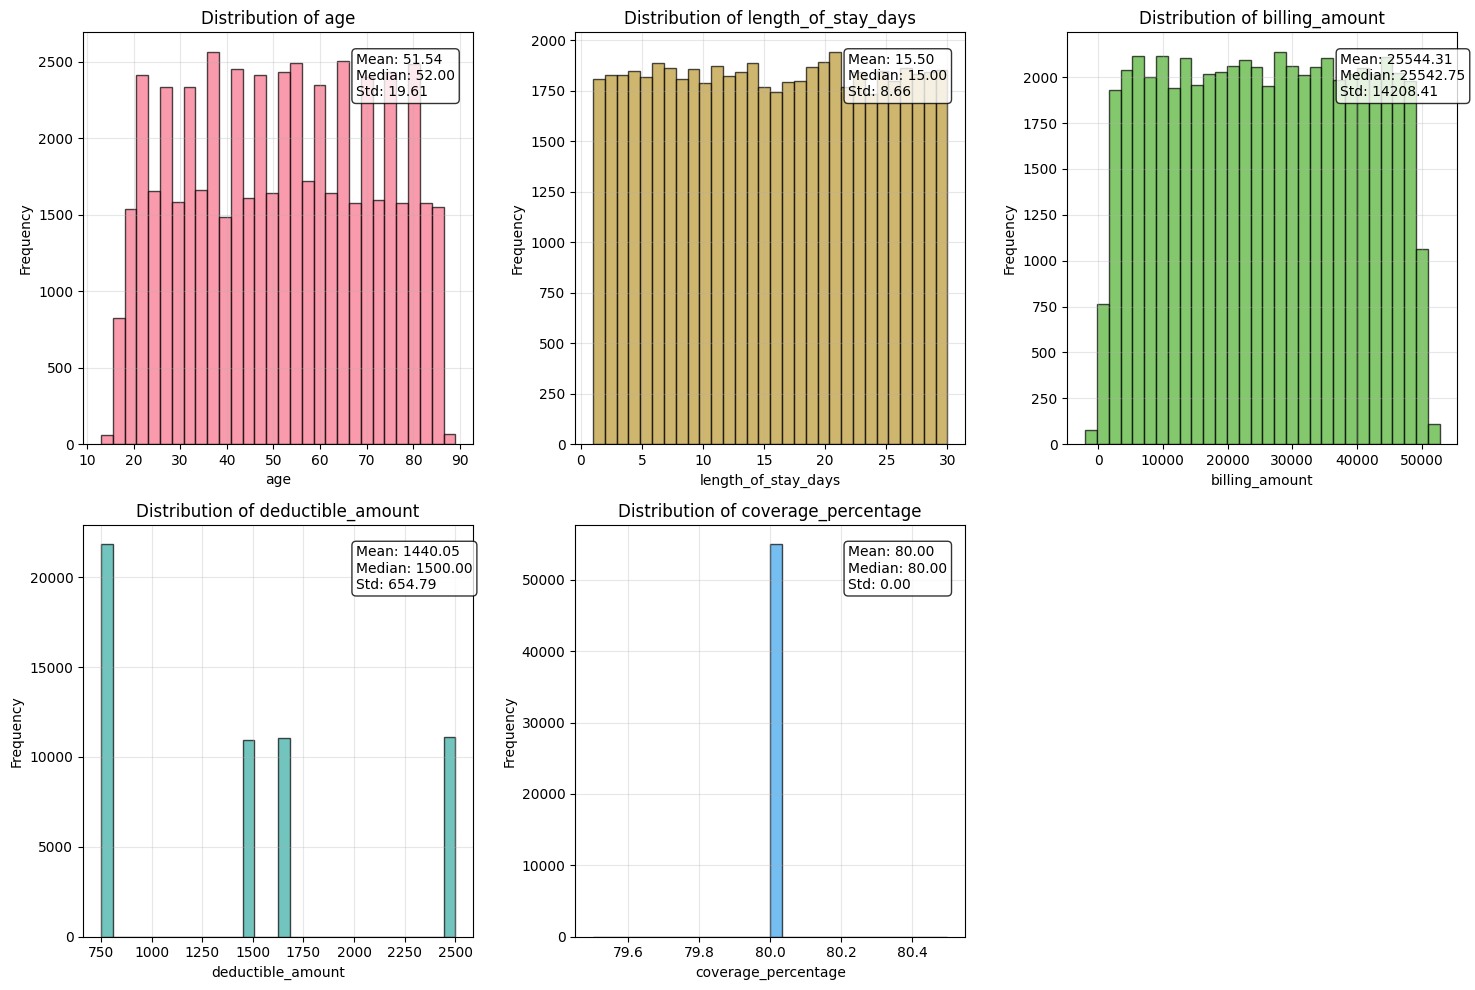

Numeric distribution analysis complete

2. CATEGORICAL ANALYSIS - Count Distributions


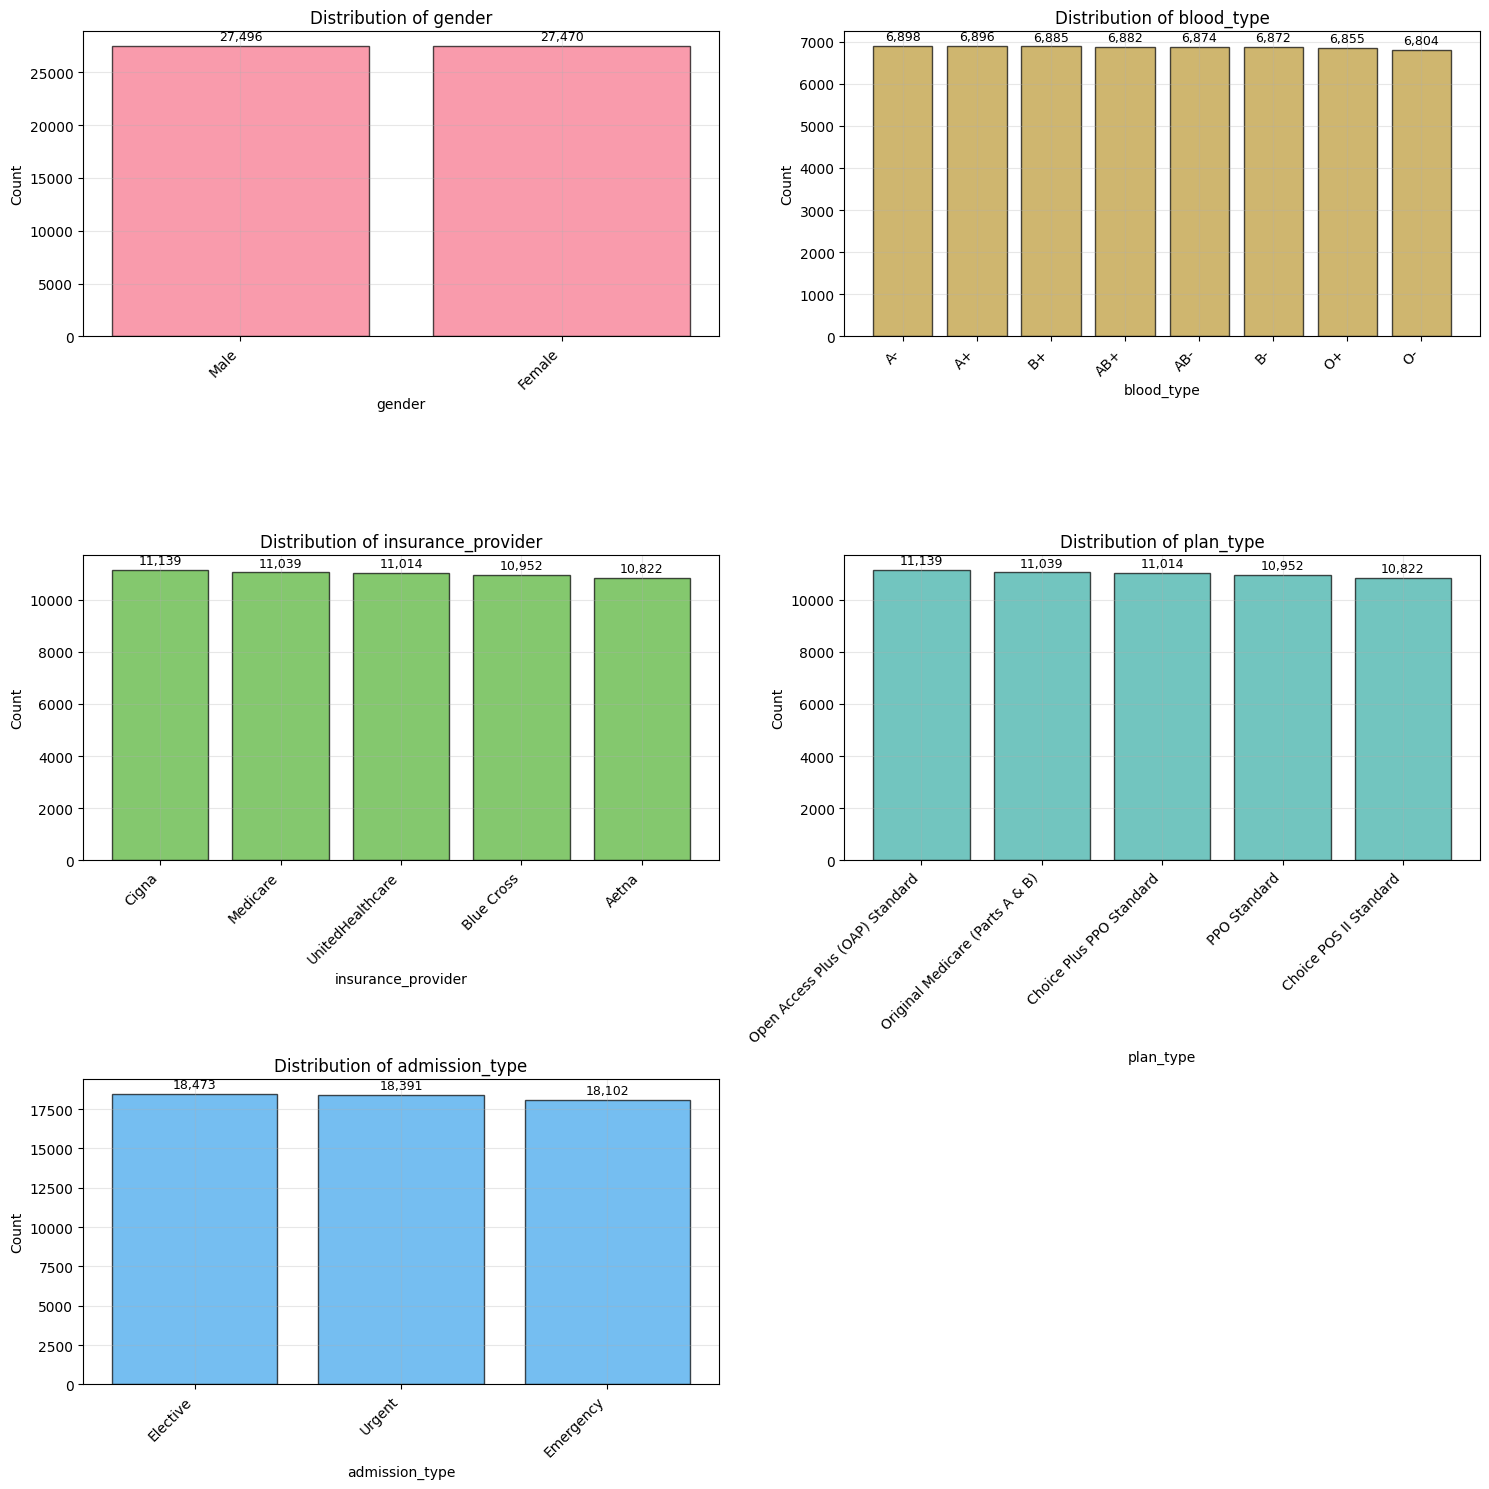

Categorical distribution analysis complete

3. CORRELATION ANALYSIS - Numeric Features


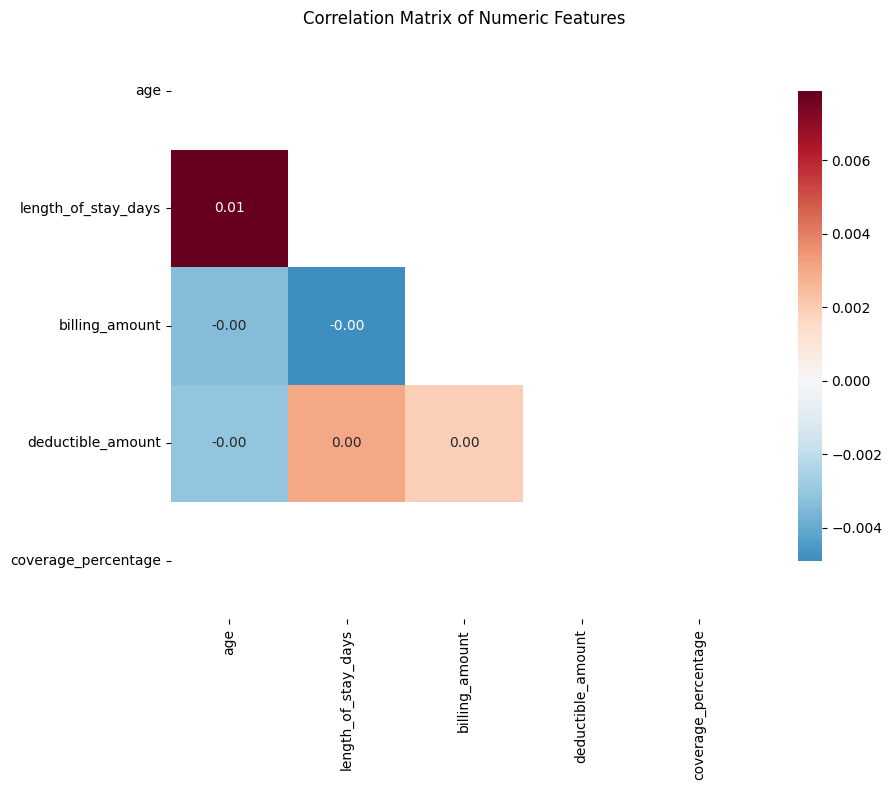

Strong correlations (|r| > 0.5):
   No strong correlations found
Correlation analysis complete

EDA SUMMARY:
   Analyzed 5 numeric features
   Analyzed 5 categorical features
   Generated distribution plots and correlation analysis
   All visualizations displayed inline


In [46]:
# Comprehensive EDA with inline visualizations
print("EXPLORATORY DATA ANALYSIS")
print("=" * 40)

# Set up the plotting environment
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Identify numeric and categorical columns for visualization
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric columns for analysis: {len(numeric_cols)}")
print(f"Categorical columns for analysis: {len(categorical_cols)}")

# Filter columns that exist and have reasonable cardinality for visualization
viz_numeric_cols = [col for col in ['age', 'length_of_stay_days', 'billing_amount', 
                                   'deductible_amount', 'coverage_percentage'] if col in numeric_cols]
viz_categorical_cols = [col for col in ['gender', 'blood_type', 'insurance_provider', 
                                       'plan_type', 'admission_type'] if col in categorical_cols]

print(f"Selected numeric columns for visualization: {viz_numeric_cols}")
print(f"Selected categorical columns for visualization: {viz_categorical_cols}")

# 1. Histograms of numeric columns
if viz_numeric_cols:
    print(f"\n1. DISTRIBUTION ANALYSIS - Numeric Features")
    
    n_cols = len(viz_numeric_cols)
    n_rows = (n_cols + 2) // 3  # Arrange in 3 columns
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for i, col in enumerate(viz_numeric_cols):
        if col in df.columns:
            # Handle special values and convert to numeric
            series = pd.to_numeric(df[col], errors='coerce')
            
            # Remove outliers for better visualization (keep values within 3 std)
            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            series_clean = series[(series >= lower_bound) & (series <= upper_bound)]
            
            axes[i].hist(series_clean.dropna(), bins=30, alpha=0.7, color=f'C{i}', edgecolor='black')
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)
            
            # Add statistics text
            stats_text = f'Mean: {series.mean():.2f}\nMedian: {series.median():.2f}\nStd: {series.std():.2f}'
            axes[i].text(0.7, 0.95, stats_text, transform=axes[i].transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print("Numeric distribution analysis complete")

# 2. Count plots of categorical columns
if viz_categorical_cols:
    print(f"\n2. CATEGORICAL ANALYSIS - Count Distributions")
    
    n_cols = len(viz_categorical_cols)
    n_rows = (n_cols + 1) // 2  # Arrange in 2 columns
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(viz_categorical_cols):
        if col in df.columns:
            # Get value counts and limit to top 10 for readability
            value_counts = df[col].value_counts().head(10)
            
            # Create bar plot
            bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                              color=f'C{i}', alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            axes[i].set_xticks(range(len(value_counts)))
            axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
            axes[i].grid(True, alpha=0.3)
            
            # Add count labels on bars
            for bar, count in zip(bars, value_counts.values):
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + count*0.01,
                            f'{count:,}', ha='center', va='bottom', fontsize=9)
    
    # Hide empty subplot if odd number of columns
    if n_cols % 2 == 1 and n_rows > 1:
        axes[-1].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print("Categorical distribution analysis complete")

# 3. Correlation heatmap of numeric features
if len(viz_numeric_cols) > 1:
    print(f"\n3. CORRELATION ANALYSIS - Numeric Features")
    
    # Convert to numeric and calculate correlation
    numeric_data = df[viz_numeric_cols].apply(pd.to_numeric, errors='coerce')
    correlation_matrix = numeric_data.corr()
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Show only lower triangle
    
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={'shrink': 0.8})
    
    plt.title('Correlation Matrix of Numeric Features')
    plt.tight_layout()
    plt.show()
    
    # Print strong correlations
    print("Strong correlations (|r| > 0.5):")
    strong_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                strong_corr.append((correlation_matrix.columns[i], 
                                  correlation_matrix.columns[j], 
                                  corr_val))
    
    if strong_corr:
        for col1, col2, corr in strong_corr:
            print(f"   {col1} ↔ {col2}: {corr:.3f}")
    else:
        print("   No strong correlations found")
    
    print("Correlation analysis complete")

print(f"\nEDA SUMMARY:")
print(f"   Analyzed {len(viz_numeric_cols)} numeric features")
print(f"   Analyzed {len(viz_categorical_cols)} categorical features")
print(f"   Generated distribution plots and correlation analysis")
print(f"   All visualizations displayed inline")

## Step 5: Separate Columns by Data Type

In [47]:
# Categorize columns by their characteristics for appropriate preprocessing

# Numeric columns (already numeric)
numeric_columns = [
    'age', 'length_of_stay_days', 'billing_amount', 'coverage_percentage',
    'max_coverage_amount', 'copay_percentage', 'deductible_amount',
    'annual_out_of_pocket_max', 'waiting_period'
]

# Low-cardinality categorical columns (suitable for one-hot encoding)
low_cardinality_categorical = [
    'gender', 'blood_type', 'admission_type', 'test_results', 'plan_type'
]

# High-cardinality categorical columns (need special handling)
high_cardinality_categorical = [
    'medical_condition', 'medication', 'insurance_provider'
]

# Multi-valued textual columns with policy rules (extract binary features)
policy_rule_columns = [
    'excluded_conditions', 'medication_coverage', 'diagnostic_test_coverage',
    'admission_type_rules', 'pre_existing_condition_coverage',
    'network_coverage', 'emergency_coverage', 'preventive_care_coverage'
]

# Filter columns that actually exist in the dataset
existing_numeric = [col for col in numeric_columns if col in df.columns]
existing_low_cat = [col for col in low_cardinality_categorical if col in df.columns]
existing_high_cat = [col for col in high_cardinality_categorical if col in df.columns]
existing_policy = [col for col in policy_rule_columns if col in df.columns]

print("COLUMN CATEGORIZATION:")
print(f"\nNumeric columns ({len(existing_numeric)}):")
for col in existing_numeric:
    print(f"   - {col}")

print(f"\nLow-cardinality categorical ({len(existing_low_cat)}):")
for col in existing_low_cat:
    unique_count = df[col].nunique() if col in df.columns else 0
    print(f"   - {col} ({unique_count} unique)")

print(f"\nHigh-cardinality categorical ({len(existing_high_cat)}):")
for col in existing_high_cat:
    unique_count = df[col].nunique() if col in df.columns else 0
    print(f"   - {col} ({unique_count} unique)")

print(f"\nPolicy rule columns ({len(existing_policy)}):")
for col in existing_policy:
    print(f"   - {col}")

COLUMN CATEGORIZATION:

Numeric columns (9):
   - age
   - length_of_stay_days
   - billing_amount
   - coverage_percentage
   - max_coverage_amount
   - copay_percentage
   - deductible_amount
   - annual_out_of_pocket_max
   - waiting_period

Low-cardinality categorical (5):
   - gender (2 unique)
   - blood_type (8 unique)
   - admission_type (3 unique)
   - test_results (3 unique)
   - plan_type (5 unique)

High-cardinality categorical (3):
   - medical_condition (6 unique)
   - medication (5 unique)
   - insurance_provider (5 unique)

Policy rule columns (8):
   - excluded_conditions
   - medication_coverage
   - diagnostic_test_coverage
   - admission_type_rules
   - pre_existing_condition_coverage
   - network_coverage
   - emergency_coverage
   - preventive_care_coverage


## Step 6: Handle Missing Values and Special Text Values

In [48]:
# Create a copy for processing
df_processed = df.copy()
imputation_log = []

print("HANDLING MISSING VALUES AND SPECIAL TEXT VALUES:")
print("=" * 50)

# STEP 1: Convert Boolean Columns to Integer (0/1)
print("\n1. Converting boolean columns to integer (0/1):")
boolean_conversion_log = []

for col in df_processed.columns:
    # Check if column contains boolean data
    if df_processed[col].dtype == 'bool':
        df_processed[col] = df_processed[col].astype(int)
        boolean_conversion_log.append(f"Converted boolean '{col}' to integer (0/1)")
        print(f"   - {col}: boolean dtype → integer")
    
    # Check for string boolean values like 'True'/'False'
    elif df_processed[col].dtype == 'object':
        unique_vals = df_processed[col].dropna().astype(str).str.lower().unique()
        if len(unique_vals) <= 2 and all(val in ['true', 'false', '1', '0', 'yes', 'no'] for val in unique_vals):
            # Convert string booleans to integers
            mapping = {'true': 1, 'false': 0, '1': 1, '0': 0, 'yes': 1, 'no': 0}
            df_processed[col] = df_processed[col].astype(str).str.lower().map(mapping).fillna(0).astype(int)
            boolean_conversion_log.append(f"Converted string boolean '{col}' to integer (0/1)")
            print(f"   - {col}: string boolean → integer")

if boolean_conversion_log:
    print(f"   Total boolean conversions: {len(boolean_conversion_log)}")
else:
    print("   No boolean columns found")

# STEP 2: Handle Special Text Values and Key Numeric Columns
print("\n2. Converting special text values to numeric:")
special_values_log = []

# Define key numeric columns for special handling
key_numeric_columns = [
    'coverage_percentage', 'max_coverage_amount', 'copay_percentage', 
    'waiting_period', 'pre_existing_condition_coverage', 'preventive_care_coverage',
    'billing_amount', 'deductible_amount', 'annual_out_of_pocket_max'
]

existing_key_numeric = [col for col in key_numeric_columns if col in df_processed.columns]
print(f"   Key numeric columns to process: {existing_key_numeric}")

for col in df_processed.columns:
    if df_processed[col].dtype == 'object':
        original_dtype = df_processed[col].dtype
        
        # Special handling for key numeric columns
        if col in existing_key_numeric:
            print(f"\n   Processing key numeric column: {col}")
            
            # Convert to string for processing
            col_str = df_processed[col].astype(str).str.strip().str.lower()
            
            # Handle percentage columns
            if 'percentage' in col.lower():
                print(f"     - Handling as percentage column")
                
                # Track conversions
                unlimited_count = col_str.str.contains('unlimited|infinity|no limit', na=False).sum()
                percentage_count = col_str.str.contains('%', na=False).sum()
                
                # Replace 'Unlimited' with 1.0 (100%)
                if unlimited_count > 0:
                    df_processed[col] = df_processed[col].astype(str).str.replace(
                        r'unlimited|infinity|no limit', '1.0', case=False, regex=True
                    )
                    print(f"       → Converted {unlimited_count} 'Unlimited' values to 1.0")
                
                # Convert percentages to decimals
                if percentage_count > 0:
                    df_processed[col] = df_processed[col].astype(str).str.replace('%', '')
                    # Convert to numeric and scale to decimal
                    numeric_vals = pd.to_numeric(df_processed[col], errors='coerce')
                    # If values > 1, assume they're percentages that need scaling
                    mask = numeric_vals > 1
                    numeric_vals[mask] = numeric_vals[mask] / 100.0
                    df_processed[col] = numeric_vals
                    print(f"       → Converted {percentage_count} percentage values to decimal")
                
                # Convert remaining to numeric
                df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
                special_values_log.append(f"Processed percentage column '{col}': {unlimited_count} unlimited, {percentage_count} percentages")
            
            # Handle amount/coverage columns
            elif any(keyword in col.lower() for keyword in ['amount', 'coverage', 'max_coverage']):
                print(f"     - Handling as amount/coverage column")
                
                unlimited_count = col_str.str.contains('unlimited|infinity|no limit', na=False).sum()
                
                # Replace 'Unlimited' with large number
                if unlimited_count > 0:
                    df_processed[col] = df_processed[col].astype(str).str.replace(
                        r'unlimited|infinity|no limit', '99999999', case=False, regex=True
                    )
                    print(f"       → Converted {unlimited_count} 'Unlimited' values to 99,999,999")
                
                # Remove currency symbols and convert to numeric
                df_processed[col] = df_processed[col].astype(str).str.replace(r'[$,]', '', regex=True)
                df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
                special_values_log.append(f"Processed amount column '{col}': {unlimited_count} unlimited values")
            
            # Handle waiting period columns
            elif 'waiting' in col.lower() or 'period' in col.lower():
                print(f"     - Handling as waiting period column")
                
                none_count = col_str.str.contains('none|no waiting|immediate', na=False).sum()
                days_count = col_str.str.contains('day', na=False).sum()
                months_count = col_str.str.contains('month', na=False).sum()
                
                # Convert period text to days
                period_values = df_processed[col].copy()
                for i, val in enumerate(col_str):
                    if pd.isna(df_processed[col].iloc[i]):
                        continue
                    elif any(keyword in val for keyword in ['none', 'no waiting', 'immediate']):
                        period_values.iloc[i] = 0
                    elif 'day' in val:
                        # Extract number of days
                        import re
                        numbers = re.findall(r'\d+', val)
                        if numbers:
                            period_values.iloc[i] = int(numbers[0])
                    elif 'month' in val:
                        # Convert months to days
                        numbers = re.findall(r'\d+', val)
                        if numbers:
                            period_values.iloc[i] = int(numbers[0]) * 30
                    elif 'year' in val:
                        # Convert years to days
                        numbers = re.findall(r'\d+', val)
                        if numbers:
                            period_values.iloc[i] = int(numbers[0]) * 365
                
                df_processed[col] = pd.to_numeric(period_values, errors='coerce')
                print(f"       → Converted periods: {none_count} none, {days_count} days, {months_count} months")
                special_values_log.append(f"Processed period column '{col}': {none_count + days_count + months_count} period values")
            
            # Handle coverage indicator columns
            elif any(keyword in col.lower() for keyword in ['coverage']):
                print(f"     - Handling as coverage indicator column")
                
                # Try to convert to numeric, treating text as categorical first
                if col_str.str.contains('yes|covered|included', na=False).any():
                    df_processed[col] = col_str.map({
                        'yes': 1, 'no': 0, 'covered': 1, 'not covered': 0,
                        'included': 1, 'excluded': 0, 'true': 1, 'false': 0
                    }).fillna(0).astype(int)
                    print(f"       → Converted coverage indicators to binary (0/1)")
                    special_values_log.append(f"Processed coverage column '{col}': converted to binary indicators")
                else:
                    # Try numeric conversion
                    df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        
        # General text-to-numeric conversion for other columns
        else:
            # Handle 'Unlimited' values in any remaining coverage/amount columns
            if any(keyword in col.lower() for keyword in ['coverage', 'amount', 'limit']):
                unlimited_count = df_processed[col].astype(str).str.lower().str.contains('unlimited|infinity').sum()
                if unlimited_count > 0:
                    df_processed[col] = df_processed[col].astype(str).str.replace(
                        r'unlimited|infinity', '99999999', case=False, regex=True
                    )
                    special_values_log.append(f"Converted {unlimited_count} 'Unlimited' values in '{col}' to 99999999")
                    print(f"   - {col}: {unlimited_count} 'Unlimited' values converted")
            
            # Handle percentage columns
            if 'percentage' in col.lower():
                if df_processed[col].astype(str).str.contains('%').any():
                    df_processed[col] = df_processed[col].astype(str).str.replace('%', '').astype(float) / 100
                    special_values_log.append(f"Converted percentage values in '{col}' from % to decimal")
                    print(f"   - {col}: Converted percentage format to decimal")
            
            # Try to convert to numeric where possible
            numeric_converted = pd.to_numeric(df_processed[col], errors='coerce')
            if not numeric_converted.isna().all():  # If some values could be converted
                original_nulls = df_processed[col].isna().sum()
                new_nulls = numeric_converted.isna().sum()
                if new_nulls > original_nulls:
                    print(f"   - {col}: Converted to numeric, {new_nulls - original_nulls} text values became NaN")
                df_processed[col] = numeric_converted

# STEP 3: Ensure Key Numeric Columns are Float64
print(f"\n3. Ensuring key numeric columns are float64:")
key_numeric_validation_log = []

for col in existing_key_numeric:
    if col in df_processed.columns:
        if df_processed[col].dtype != 'float64':
            original_dtype = df_processed[col].dtype
            df_processed[col] = df_processed[col].astype('float64')
            key_numeric_validation_log.append(f"Converted '{col}' from {original_dtype} to float64")
            print(f"   - {col}: {original_dtype} → float64")
        else:
            print(f"   - {col}: already float64 ✓")

print(f"   Key numeric columns validated: {len(existing_key_numeric)}")

# Update column categorization after conversion
existing_numeric = []
existing_low_cat = []
existing_high_cat = []
existing_policy = []

# Re-categorize based on actual data types and characteristics
for col in df_processed.columns:
    if df_processed[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        existing_numeric.append(col)
    elif df_processed[col].dtype in ['object', 'category']:
        unique_count = df_processed[col].nunique()
        
        # Check if it's a policy rule column (contains text patterns)
        if any(keyword in col.lower() for keyword in ['coverage', 'conditions', 'rules', 'network', 'emergency', 'preventive']):
            # Only add to policy if it's still text-based after conversions
            if df_processed[col].dtype == 'object':
                existing_policy.append(col)
        elif unique_count <= 20:  # Low cardinality
            existing_low_cat.append(col)
        else:  # High cardinality
            existing_high_cat.append(col)

print(f"\nUpdated column categorization after special value conversion:")
print(f"   Numeric columns: {len(existing_numeric)}")
print(f"   Low-cardinality categorical: {len(existing_low_cat)}")
print(f"   High-cardinality categorical: {len(existing_high_cat)}")
print(f"   Policy rule columns: {len(existing_policy)}")

# STEP 4: Handle missing values in numeric columns with domain-informed imputation
if existing_numeric:
    print(f"\n4. Numeric columns - Domain-informed imputation:")
    
    for col in existing_numeric:
        if df_processed[col].isnull().sum() > 0:
            missing_count = df_processed[col].isnull().sum()
            
            # Domain-specific imputation strategies
            if col in existing_key_numeric:
                print(f"   - {col} (KEY NUMERIC): {missing_count} missing values")
                
                if 'percentage' in col.lower():
                    # For percentages, use median or 80% default
                    median_val = df_processed[col].median()
                    fill_value = median_val if not pd.isna(median_val) else 0.8
                    df_processed[col] = df_processed[col].fillna(fill_value)
                    print(f"     → Filled with {fill_value:.3f} (percentage default)")
                    
                elif any(keyword in col.lower() for keyword in ['amount', 'coverage']):
                    # For amounts, use median or domain defaults
                    median_val = df_processed[col].median()
                    if pd.isna(median_val):
                        if 'deductible' in col.lower():
                            fill_value = 1000.0
                        elif 'max_coverage' in col.lower():
                            fill_value = 1000000.0
                        else:
                            fill_value = 0.0
                    else:
                        fill_value = median_val
                    df_processed[col] = df_processed[col].fillna(fill_value)
                    print(f"     → Filled with {fill_value:.2f} (amount default)")
                    
                elif 'waiting' in col.lower() or 'period' in col.lower():
                    # For periods, use 0 (no waiting)
                    fill_value = 0.0
                    df_processed[col] = df_processed[col].fillna(fill_value)
                    print(f"     → Filled with {fill_value} days (no waiting)")
                    
                else:
                    # General case: use median
                    median_val = df_processed[col].median()
                    fill_value = median_val if not pd.isna(median_val) else 0.0
                    df_processed[col] = df_processed[col].fillna(fill_value)
                    print(f"     → Filled with {fill_value:.2f} (median)")
                
                imputation_log.append(f"Key numeric '{col}': {missing_count} values imputed with domain-informed strategy")
            
            else:
                # Standard median imputation for other numeric columns
                median_val = df_processed[col].median()
                fill_value = median_val if not pd.isna(median_val) else 0.0
                df_processed[col] = df_processed[col].fillna(fill_value)
                imputation_log.append(f"Numeric '{col}': {missing_count} values imputed with median: {fill_value:.2f}")
                print(f"   - {col}: {missing_count} values imputed with {fill_value:.2f}")
        else:
            print(f"   - {col}: No missing values ✓")

# STEP 5: Handle missing values in categorical columns
categorical_cols = existing_low_cat + existing_high_cat + existing_policy
if categorical_cols:
    print(f"\n5. Categorical columns - Imputing with 'Unknown':")
    
    for col in categorical_cols:
        if col in df_processed.columns and df_processed[col].isnull().sum() > 0:
            missing_count = df_processed[col].isnull().sum()
            
            # Use mode if available, otherwise 'Unknown'
            mode_val = df_processed[col].mode()
            if len(mode_val) > 0 and missing_count < len(df_processed) * 0.5:
                fill_value = mode_val[0]
                strategy_used = f"mode ('{fill_value}')"
            else:
                fill_value = 'Unknown'
                strategy_used = "'Unknown'"
            
            df_processed[col] = df_processed[col].fillna(fill_value)
            imputation_log.append(f"Imputed {missing_count} missing values in '{col}' with {strategy_used}")
            print(f"   - {col}: {missing_count} values imputed with {strategy_used}")
        elif col in df_processed.columns:
            print(f"   - {col}: No missing values ✓")

# Verify no missing values remain
remaining_missing = df_processed.isnull().sum().sum()
print(f"\nTotal missing values after imputation: {remaining_missing}")

# Print comprehensive summary
if boolean_conversion_log:
    print(f"\nBoolean Conversion Summary ({len(boolean_conversion_log)} operations):")
    for i, log_entry in enumerate(boolean_conversion_log, 1):
        print(f"   {i}. {log_entry}")

if special_values_log:
    print(f"\nSpecial Value Conversion Summary ({len(special_values_log)} operations):")
    for i, log_entry in enumerate(special_values_log, 1):
        print(f"   {i}. {log_entry}")

if key_numeric_validation_log:
    print(f"\nKey Numeric Validation Summary ({len(key_numeric_validation_log)} operations):")
    for i, log_entry in enumerate(key_numeric_validation_log, 1):
        print(f"   {i}. {log_entry}")

if imputation_log:
    print(f"\nImputation Summary ({len(imputation_log)} operations):")
    for i, log_entry in enumerate(imputation_log, 1):
        print(f"   {i}. {log_entry}")

print(f"\nFinal data types after preprocessing:")
dtype_summary = df_processed.dtypes.value_counts()
for dtype_name, count in dtype_summary.items():
    print(f"   {dtype_name}: {count} columns")

# Validate key numeric columns
print(f"\nKey Numeric Columns Validation:")
for col in existing_key_numeric:
    if col in df_processed.columns:
        dtype = df_processed[col].dtype
        missing = df_processed[col].isnull().sum()
        min_val = df_processed[col].min()
        max_val = df_processed[col].max()
        print(f"   {col}: {dtype}, {missing} missing, range [{min_val:.2f}, {max_val:.2f}]")

HANDLING MISSING VALUES AND SPECIAL TEXT VALUES:

1. Converting boolean columns to integer (0/1):
   No boolean columns found

2. Converting special text values to numeric:
   Key numeric columns to process: ['coverage_percentage', 'max_coverage_amount', 'copay_percentage', 'waiting_period', 'pre_existing_condition_coverage', 'preventive_care_coverage', 'billing_amount', 'deductible_amount', 'annual_out_of_pocket_max']
   No boolean columns found

2. Converting special text values to numeric:
   Key numeric columns to process: ['coverage_percentage', 'max_coverage_amount', 'copay_percentage', 'waiting_period', 'pre_existing_condition_coverage', 'preventive_care_coverage', 'billing_amount', 'deductible_amount', 'annual_out_of_pocket_max']

   Processing key numeric column: max_coverage_amount
     - Handling as amount/coverage column
       → Converted 54966 'Unlimited' values to 99,999,999

   Processing key numeric column: annual_out_of_pocket_max

   Processing key numeric column: ma

ValueError: could not convert string to float: 'No limit'

## Step 7: Encode Low-Cardinality Categorical Variables

In [ ]:
# One-hot encode low-cardinality categorical variables
encoding_log = []
encoded_columns = []

print("ENCODING LOW-CARDINALITY CATEGORICAL VARIABLES:")
print("=" * 50)

if existing_low_cat:
    for col in existing_low_cat:
        if col in df_processed.columns:
            unique_count = df_processed[col].nunique()
            print(f"\nProcessing '{col}' ({unique_count} unique values):")
            
            # Create one-hot encoded columns
            dummies = pd.get_dummies(df_processed[col], prefix=col, dummy_na=False)
            
            # Add the new columns to the dataframe
            df_processed = pd.concat([df_processed, dummies], axis=1)
            
            # Keep track of new columns
            new_cols = list(dummies.columns)
            encoded_columns.extend(new_cols)
            
            print(f"   Created {len(new_cols)} binary columns: {new_cols}")
            encoding_log.append(f"One-hot encoded '{col}' into {len(new_cols)} binary columns")
            
            # Drop the original column
            df_processed = df_processed.drop(columns=[col])
            
    print(f"\nTotal new binary columns created: {len(encoded_columns)}")
else:
    print("No low-cardinality categorical columns to encode")

## Step 8: Handle High-Cardinality Categorical Variables

In [ ]:
# Handle high-cardinality categorical variables by grouping rare categories
print("HANDLING HIGH-CARDINALITY CATEGORICAL VARIABLES:")
print("=" * 50)

if existing_high_cat:
    for col in existing_high_cat:
        if col in df_processed.columns:
            unique_count = df_processed[col].nunique()
            print(f"\nProcessing '{col}' ({unique_count} unique values):")
            
            # Get value counts
            value_counts = df_processed[col].value_counts()
            total_rows = len(df_processed)
            
            # Keep top categories that represent at least 1% of data
            min_frequency = max(10, total_rows * 0.01)  # At least 10 occurrences or 1%
            frequent_categories = value_counts[value_counts >= min_frequency].index.tolist()
            
            print(f"   Keeping {len(frequent_categories)} frequent categories (>= {min_frequency:.0f} occurrences)")
            print(f"   Top 5: {frequent_categories[:5]}")
            
            # Replace rare categories with 'Other'
            df_processed[f'{col}_grouped'] = df_processed[col].apply(
                lambda x: x if x in frequent_categories else 'Other'
            )
            
            # One-hot encode the grouped version
            dummies = pd.get_dummies(df_processed[f'{col}_grouped'], prefix=col, dummy_na=False)
            df_processed = pd.concat([df_processed, dummies], axis=1)
            
            # Keep track of new columns
            new_cols = list(dummies.columns)
            encoded_columns.extend(new_cols)
            
            print(f"   Created {len(new_cols)} binary columns after grouping")
            encoding_log.append(f"Grouped '{col}' rare categories and created {len(new_cols)} binary columns")
            
            # Drop original and intermediate columns
            df_processed = df_processed.drop(columns=[col, f'{col}_grouped'])
            
else:
    print("No high-cardinality categorical columns to process")

## Step 9: Extract Binary Features from Policy Rule Columns

In [ ]:
# Extract binary indicator features from multi-valued textual policy columns
print("EXTRACTING BINARY FEATURES FROM POLICY RULE COLUMNS:")
print("=" * 55)

policy_feature_log = []
binary_features_created = []

# Common patterns to extract from policy text columns
policy_patterns = {
    'cosmetic_surgery': r'cosmetic|aesthetic|plastic surgery|elective',
    'self_inflicted': r'self.inflicted|self.harm|intentional',
    'experimental': r'experimental|investigational|clinical trial',
    'dental': r'dental|orthodontic|teeth',
    'vision': r'vision|eye|optical|glasses|contacts',
    'mental_health': r'mental|psychiatric|psychology|counseling',
    'maternity': r'maternity|pregnancy|prenatal|obstetric',
    'emergency': r'emergency|urgent|critical',
    'preventive': r'preventive|prevention|screening|wellness|checkup',
    'specialist': r'specialist|referral|consultation',
    'prescription': r'prescription|medication|drug|pharmacy',
    'inpatient': r'inpatient|hospital|admission',
    'outpatient': r'outpatient|clinic|office visit'
}

if existing_policy:
    for col in existing_policy:
        if col in df_processed.columns:
            print(f"\nProcessing '{col}':")
            
            # Convert to string and handle NaN
            text_series = df_processed[col].astype(str).str.lower()
            
            # Extract binary features based on patterns
            col_features = []
            for pattern_name, pattern in policy_patterns.items():
                feature_name = f'{col}_{pattern_name}'
                df_processed[feature_name] = text_series.str.contains(pattern, regex=True, na=False).astype(int)
                
                # Only keep features that have some variation (not all 0s or all 1s)
                feature_sum = df_processed[feature_name].sum()
                if 0 < feature_sum < len(df_processed):
                    col_features.append(feature_name)
                    binary_features_created.append(feature_name)
                    print(f"   - {feature_name}: {feature_sum} positive cases ({feature_sum/len(df_processed)*100:.1f}%)")
                else:
                    # Drop features with no variation
                    df_processed = df_processed.drop(columns=[feature_name])
            
            policy_feature_log.append(f"Extracted {len(col_features)} binary features from '{col}'")
            
            # Drop the original text column
            df_processed = df_processed.drop(columns=[col])
            
    print(f"\nTotal binary policy features created: {len(binary_features_created)}")
else:
    print("No policy rule columns to process")

if policy_feature_log:
    print(f"\nPolicy Feature Extraction Summary:")
    for i, log_entry in enumerate(policy_feature_log, 1):
        print(f"   {i}. {log_entry}")

## Step 10: Scale Numerical Features

In [ ]:
# Scale numerical features using StandardScaler
print("SCALING NUMERICAL FEATURES:")
print("=" * 30)

scaling_log = []
scaler = StandardScaler()

if existing_numeric:
    # Filter numeric columns that still exist in the processed dataframe
    numeric_to_scale = [col for col in existing_numeric if col in df_processed.columns]
    
    if numeric_to_scale:
        print(f"\nScaling {len(numeric_to_scale)} numerical columns:")
        
        # Store original statistics for reference
        original_stats = df_processed[numeric_to_scale].describe()
        
        # Apply scaling
        df_processed[numeric_to_scale] = scaler.fit_transform(df_processed[numeric_to_scale])
        
        # Store scaled statistics
        scaled_stats = df_processed[numeric_to_scale].describe()
        
        for col in numeric_to_scale:
            orig_mean = original_stats.loc['mean', col]
            orig_std = original_stats.loc['std', col]
            scaled_mean = scaled_stats.loc['mean', col]
            scaled_std = scaled_stats.loc['std', col]
            
            print(f"   - {col}:")
            print(f"     Original: mean={orig_mean:.2f}, std={orig_std:.2f}")
            print(f"     Scaled:   mean={scaled_mean:.2f}, std={scaled_std:.2f}")
            
            scaling_log.append(f"Scaled '{col}' (mean: {orig_mean:.2f} → {scaled_mean:.2f})")
        
        print(f"\nAll numerical features have been standardized (mean≈0, std≈1)")
    else:
        print("No numerical columns found to scale")
else:
    print("No numerical columns defined for scaling")

## Step 11: Final Dataset Cleanup and Validation

In [ ]:
# Final cleanup and validation with comprehensive data type checking
print("FINAL DATASET CLEANUP AND VALIDATION:")
print("=" * 40)

# STEP 1: Final Boolean and Data Type Validation
print("\n1. FINAL DATA TYPE VALIDATION:")
final_validation_log = []

# Check for any remaining boolean columns and convert
boolean_cols = df_processed.select_dtypes(include=['bool']).columns.tolist()
if boolean_cols:
    print(f"   Found {len(boolean_cols)} remaining boolean columns to convert:")
    for col in boolean_cols:
        df_processed[col] = df_processed[col].astype(int)
        final_validation_log.append(f"Final conversion: '{col}' boolean → integer")
        print(f"     - {col}: boolean → integer")
else:
    print("   ✓ No boolean columns remaining")

# Ensure all key numeric columns are properly typed
key_numeric_columns = [
    'coverage_percentage', 'max_coverage_amount', 'copay_percentage', 
    'waiting_period', 'pre_existing_condition_coverage', 'preventive_care_coverage',
    'billing_amount', 'deductible_amount'
]

existing_key_numeric = [col for col in key_numeric_columns if col in df_processed.columns]
print(f"\n2. KEY NUMERIC COLUMNS FINAL VALIDATION:")
print(f"   Target columns for validation: {len(existing_key_numeric)}")

for col in existing_key_numeric:
    current_dtype = df_processed[col].dtype
    missing_count = df_processed[col].isnull().sum()
    
    # Ensure float64 dtype
    if current_dtype != 'float64':
        df_processed[col] = df_processed[col].astype('float64')
        final_validation_log.append(f"Final type conversion: '{col}' {current_dtype} → float64")
        print(f"   - {col}: {current_dtype} → float64")
    else:
        print(f"   - {col}: ✓ float64 ({missing_count} missing)")
    
    # Validate ranges for specific column types
    if col in df_processed.columns:
        min_val = df_processed[col].min()
        max_val = df_processed[col].max()
        
        if 'percentage' in col.lower():
            if min_val < 0 or max_val > 1:
                print(f"     ⚠️  Warning: {col} values outside expected range [0,1]: [{min_val:.3f}, {max_val:.3f}]")
        elif 'amount' in col.lower():
            if min_val < 0:
                print(f"     ⚠️  Warning: {col} has negative values: min = {min_val:.2f}")
        elif 'waiting' in col.lower() or 'period' in col.lower():
            if min_val < 0:
                print(f"     ⚠️  Warning: {col} has negative periods: min = {min_val:.2f}")

# STEP 3: Check for any remaining non-numeric columns
print(f"\n3. NON-NUMERIC COLUMNS CHECK:")
non_numeric_cols = df_processed.select_dtypes(include=['object', 'category']).columns.tolist()
if non_numeric_cols:
    print(f"   Found {len(non_numeric_cols)} non-numeric columns:")
    for col in non_numeric_cols:
        unique_count = df_processed[col].nunique()
        print(f"     - {col} ({df_processed[col].dtype}): {unique_count} unique values")
        
        # Attempt to convert categorical columns to numeric codes if they're truly categorical
        if df_processed[col].dtype == 'category':
            df_processed[col] = df_processed[col].cat.codes
            final_validation_log.append(f"Converted categorical '{col}' to numeric codes")
            print(f"       → Converted to numeric codes")
        
        # For object columns with low cardinality, try label encoding
        elif unique_count <= 50:  # Reasonable threshold for label encoding
            from sklearn.preprocessing import LabelEncoder
            label_encoder = LabelEncoder()
            df_processed[f'{col}_encoded'] = label_encoder.fit_transform(df_processed[col].astype(str))
            final_validation_log.append(f"Label encoded '{col}' as '{col}_encoded'")
            print(f"       → Created label encoded version: {col}_encoded")
else:
    print("   ✓ All columns are now numeric - ready for ML models")

# STEP 4: Verify no missing values in key columns
print(f"\n4. MISSING VALUES FINAL CHECK:")
total_missing = df_processed.isnull().sum().sum()
print(f"   Total missing values across all columns: {total_missing}")

if total_missing > 0:
    print("   Columns with missing values:")
    missing_summary = df_processed.isnull().sum()
    missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
    for col, count in missing_summary.items():
        pct = (count / len(df_processed)) * 100
        print(f"     - {col}: {count:,} ({pct:.1f}%)")
    
    # Final imputation for any remaining missing values
    print("   Applying final imputation...")
    for col in missing_summary.index:
        if df_processed[col].dtype in ['float64', 'int64']:
            fill_value = df_processed[col].median()
            if pd.isna(fill_value):
                fill_value = 0
            df_processed[col] = df_processed[col].fillna(fill_value)
            print(f"     → {col}: filled with {fill_value}")
        else:
            df_processed[col] = df_processed[col].fillna('Unknown')
            print(f"     → {col}: filled with 'Unknown'")
else:
    print("   ✓ No missing values found")

# STEP 5: Check for infinite or extremely large values
print(f"\n5. INFINITE VALUES CHECK:")
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
infinite_values = np.isinf(df_processed[numeric_cols]).sum().sum()
print(f"   Infinite values found: {infinite_values}")

if infinite_values > 0:
    # Replace infinite values with large finite numbers or NaN, then impute
    print("   Replacing infinite values...")
    df_processed = df_processed.replace([np.inf, -np.inf], np.nan)
    
    # Impute any new NaN values created from infinite replacement
    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            median_val = df_processed[col].median()
            fill_value = median_val if not pd.isna(median_val) else 0
            df_processed[col] = df_processed[col].fillna(fill_value)
    
    print("   ✓ Infinite values replaced and imputed")
else:
    print("   ✓ No infinite values found")

# STEP 6: Final dataset summary
print(f"\n6. FINAL DATASET SUMMARY:")
print(f"   Shape: {df_processed.shape[0]:,} rows × {df_processed.shape[1]} columns")
print(f"   Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   Total missing values: {df_processed.isnull().sum().sum()}")
print(f"   Data types:")

dtype_summary = df_processed.dtypes.value_counts()
for dtype_name, count in dtype_summary.items():
    print(f"     {dtype_name}: {count} columns")

# Check percentage of numeric columns
numeric_cols_count = len(df_processed.select_dtypes(include=[np.number]).columns)
total_cols = len(df_processed.columns)
numeric_percentage = (numeric_cols_count / total_cols) * 100

print(f"   Numeric columns: {numeric_cols_count}/{total_cols} ({numeric_percentage:.1f}%)")

# Final validation log summary
if final_validation_log:
    print(f"\nFinal Validation Operations ({len(final_validation_log)}):")
    for i, log_entry in enumerate(final_validation_log, 1):
        print(f"   {i}. {log_entry}")

print(f"\n✓ Dataset validation complete - Ready for ML model training!")

## Step 12: Save Final ML-Ready Dataset

In [ ]:
# Save the final ML-ready dataset (overwriting previous version)
try:
    print(f"Saving final ML-ready dataset to: {output_file}")
    print(f"This will overwrite any existing file at this location.")
    
    # Create backup if file already exists
    if output_file.exists():
        backup_file = output_file.parent / f"{output_file.stem}_backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        import shutil
        shutil.copy2(output_file, backup_file)
        print(f"Created backup of existing file: {backup_file.name}")
    
    # Save the main dataset
    df_processed.to_csv(output_file, index=False)
    
    # Verify the saved file
    if output_file.exists():
        file_size = output_file.stat().st_size / 1024**2  # Size in MB
        print(f"✓ Successfully saved dataset!")
        print(f"   File size: {file_size:.2f} MB")
        print(f"   Location: {output_file}")
        print(f"   Overwrite: {'Yes' if backup_file.exists() else 'New file'}")
        
        # Quick verification by reading back a few rows
        verification_df = pd.read_csv(output_file, nrows=5)
        print(f"   Verification: Successfully read back {len(verification_df)} rows")
        
        # Verify data types were preserved
        print(f"   Data types verification:")
        for col in existing_key_numeric:
            if col in verification_df.columns:
                dtype = verification_df[col].dtype
                print(f"     {col}: {dtype}")
                if dtype not in ['float64', 'int64']:
                    print(f"       ⚠️  Warning: {col} saved as {dtype} instead of numeric")
        
        # Check for boolean columns in saved file
        saved_bool_cols = verification_df.select_dtypes(include=['bool']).columns.tolist()
        if saved_bool_cols:
            print(f"   ⚠️  Warning: {len(saved_bool_cols)} boolean columns found in saved file")
        else:
            print(f"   ✓ No boolean columns in saved file")
    else:
        print("❌ Error: File was not created successfully")
        
except Exception as e:
    print(f"❌ Error saving file: {str(e)}")
    raise

# Create comprehensive metadata with all processing steps
metadata = {
    'processing_timestamp': datetime.now().isoformat(),
    'input_file': str(input_file),
    'output_file': str(output_file),
    'original_shape': list(df.shape),
    'final_shape': list(df_processed.shape),
    'features_created': len(encoded_columns) + len(binary_features_created),
    'boolean_conversion_operations': boolean_conversion_log if 'boolean_conversion_log' in locals() else [],
    'special_value_operations': special_values_log if 'special_values_log' in locals() else [],
    'key_numeric_validation_operations': key_numeric_validation_log if 'key_numeric_validation_log' in locals() else [],
    'encoding_operations': encoding_log,
    'imputation_operations': imputation_log,
    'policy_feature_operations': policy_feature_log,
    'scaling_operations': scaling_log,
    'final_validation_operations': final_validation_log if 'final_validation_log' in locals() else [],
    'encoded_columns': encoded_columns,
    'binary_policy_features': binary_features_created,
    'key_numeric_columns_processed': existing_key_numeric,
    'final_column_types': {col: str(dtype) for col, dtype in df_processed.dtypes.to_dict().items()},
    'numeric_columns_scaled': [col for col in existing_numeric if col in df_processed.columns],
    'data_quality_summary': {
        'total_missing_values': int(df_processed.isnull().sum().sum()),
        'infinite_values': int(np.isinf(df_processed.select_dtypes(include=[np.number])).sum().sum()),
        'boolean_columns_remaining': len(df_processed.select_dtypes(include=['bool']).columns),
        'numeric_columns_count': len(df_processed.select_dtypes(include=[np.number]).columns),
        'total_columns': len(df_processed.columns)
    }
}

metadata_file = ml_outputs_dir / 'ml_final_preparation_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nComprehensive metadata saved to: {metadata_file}")

# Final summary with all operations
print(f"\nFINAL PROCESSING SUMMARY:")
total_operations = (
    len(boolean_conversion_log if 'boolean_conversion_log' in locals() else []) +
    len(special_values_log if 'special_values_log' in locals() else []) +
    len(key_numeric_validation_log if 'key_numeric_validation_log' in locals() else []) +
    len(imputation_log) + len(encoding_log) + len(policy_feature_log) + len(scaling_log) +
    len(final_validation_log if 'final_validation_log' in locals() else [])
)
print(f"   Total processing operations: {total_operations}")
print(f"   - Boolean conversions: {len(boolean_conversion_log if 'boolean_conversion_log' in locals() else [])}")
print(f"   - Special value conversions: {len(special_values_log if 'special_values_log' in locals() else [])}")
print(f"   - Key numeric validations: {len(key_numeric_validation_log if 'key_numeric_validation_log' in locals() else [])}")
print(f"   - Imputation operations: {len(imputation_log)}")
print(f"   - Encoding operations: {len(encoding_log)}")
print(f"   - Policy feature extractions: {len(policy_feature_log)}")
print(f"   - Scaling operations: {len(scaling_log)}")
print(f"   - Final validations: {len(final_validation_log if 'final_validation_log' in locals() else [])}")

print(f"\n🎯 Dataset saved and ready for Gradient Boosting regression training!")
print(f"   All key numeric columns properly typed as float64")
print(f"   All boolean columns converted to integer (0/1)")
print(f"   All text placeholders ('Unlimited', etc.) converted to numeric")
print(f"   All missing values imputed with domain-appropriate strategies")
print(f"   File location: {output_file}")

## Step 13: Final Dataset Summary and Preview

In [ ]:
# Comprehensive final summary
print("ML FINAL PREPARATION COMPLETE")
print("=" * 60)

print(f"\nFINAL DATASET SUMMARY:")
print(f"   Original shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"   Final shape: {df_processed.shape[0]:,} rows × {df_processed.shape[1]} columns")
print(f"   Features added: {df_processed.shape[1] - df.shape[1]}")
print(f"   Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   All columns numeric: {df_processed.select_dtypes(include=[np.number]).shape[1] == df_processed.shape[1]}")

print(f"\nPREPROCESSING OPERATIONS PERFORMED:")
total_operations = len(imputation_log) + len(encoding_log) + len(policy_feature_log) + len(scaling_log)
print(f"   Total operations: {total_operations}")
print(f"   - Imputation operations: {len(imputation_log)}")
print(f"   - Encoding operations: {len(encoding_log)}")
print(f"   - Policy feature extractions: {len(policy_feature_log)}")
print(f"   - Scaling operations: {len(scaling_log)}")

print(f"\nFEATURE ENGINEERING RESULTS:")
print(f"   One-hot encoded features: {len([col for col in encoded_columns if col in df_processed.columns])}")
print(f"   Binary policy features: {len([col for col in binary_features_created if col in df_processed.columns])}")
print(f"   Scaled numerical features: {len([col for col in existing_numeric if col in df_processed.columns])}")

print(f"\nDATA QUALITY VALIDATION:")
print(f"   Missing values: {df_processed.isnull().sum().sum()}")
print(f"   Infinite values: {np.isinf(df_processed.select_dtypes(include=[np.number])).sum().sum()}")
print(f"   Non-numeric columns: {len(df_processed.select_dtypes(exclude=[np.number]).columns)}")

print(f"\nSAMPLE DATA (First 5 rows, first 10 columns):")
display(df_processed.iloc[:5, :10])

print(f"\nCOLUMN STATISTICS (First 10 columns):")
display(df_processed.iloc[:, :10].describe())

print(f"\nDataset is now fully prepared for ML modeling!")
print(f"Output saved to: {output_file}")
print(f"\nRecommended next steps:")
print(f"   1. Load this dataset for model training")
print(f"   2. Split into train/validation/test sets")
print(f"   3. Apply your chosen ML algorithms")
print(f"   4. Evaluate model performance")

In [ ]:
# Comprehensive before/after data type and processing comparison
print("BEFORE/AFTER PROCESSING COMPARISON")
print("=" * 60)

# Data type comparison
print(f"\nDATA TYPE COMPARISON:")
print(f"{'Column Name':<35} {'Original':<15} {'Final':<15} {'Status'}")
print("-" * 80)

# Get sample of columns to show transformation
key_columns_to_show = []
# Add key numeric columns
key_columns_to_show.extend([col for col in existing_key_numeric if col in df_processed.columns][:5])
# Add some encoded columns
key_columns_to_show.extend([col for col in encoded_columns if col in df_processed.columns][:3])
# Add some policy features
key_columns_to_show.extend([col for col in binary_features_created if col in df_processed.columns][:3])

for col in key_columns_to_show:
    if col in df.columns and col in df_processed.columns:
        orig_dtype = str(df[col].dtype)
        final_dtype = str(df_processed[col].dtype)
        
        if orig_dtype != final_dtype:
            status = "✓ CONVERTED"
        else:
            status = "UNCHANGED"
        
        print(f"{col:<35} {orig_dtype:<15} {final_dtype:<15} {status}")

# Show new columns created
print(f"\nNEW COLUMNS CREATED:")
new_columns = [col for col in df_processed.columns if col not in df.columns]
if new_columns:
    print(f"   Total new columns: {len(new_columns)}")
    print(f"   One-hot encoded: {len([col for col in encoded_columns if col in df_processed.columns])}")
    print(f"   Policy features: {len([col for col in binary_features_created if col in df_processed.columns])}")
    print(f"   Sample new columns: {new_columns[:5]}")
else:
    print("   No new columns created")

# Missing values comparison
orig_missing = df.isnull().sum().sum()
final_missing = df_processed.isnull().sum().sum()
print(f"\nMISSING VALUES COMPARISON:")
print(f"   Original dataset: {orig_missing:,} missing values")
print(f"   Final dataset: {final_missing:,} missing values")
print(f"   Reduction: {orig_missing - final_missing:,} missing values eliminated")

# Memory usage comparison
orig_memory = df.memory_usage(deep=True).sum() / 1024**2
final_memory = df_processed.memory_usage(deep=True).sum() / 1024**2
print(f"\nMEMORY USAGE COMPARISON:")
print(f"   Original dataset: {orig_memory:.2f} MB")
print(f"   Final dataset: {final_memory:.2f} MB")
print(f"   Change: {final_memory - orig_memory:+.2f} MB ({((final_memory/orig_memory - 1) * 100):+.1f}%)")

# Column count comparison
print(f"\nCOLUMN COUNT COMPARISON:")
print(f"   Original columns: {df.shape[1]}")
print(f"   Final columns: {df_processed.shape[1]}")
print(f"   Net change: {df_processed.shape[1] - df.shape[1]:+d} columns")

# Data type distribution comparison
print(f"\nDATA TYPE DISTRIBUTION:")
print(f"   ORIGINAL DATASET:")
orig_types = df.dtypes.value_counts()
for dtype, count in orig_types.items():
    print(f"     {dtype}: {count} columns ({count/df.shape[1]*100:.1f}%)")

print(f"   FINAL DATASET:")
final_types = df_processed.dtypes.value_counts()
for dtype, count in final_types.items():
    print(f"     {dtype}: {count} columns ({count/df_processed.shape[1]*100:.1f}%)")

# Numeric readiness summary
numeric_cols_final = len(df_processed.select_dtypes(include=[np.number]).columns)
total_cols_final = len(df_processed.columns)
numeric_percentage = (numeric_cols_final / total_cols_final) * 100

print(f"\nML READINESS SUMMARY:")
print(f"   ✓ Numeric columns: {numeric_cols_final}/{total_cols_final} ({numeric_percentage:.1f}%)")
print(f"   ✓ Boolean columns converted: {len(boolean_conversion_log if 'boolean_conversion_log' in locals() else [])}")
print(f"   ✓ Key numeric columns validated: {len(existing_key_numeric)}")
print(f"   ✓ Missing values eliminated: {orig_missing}")
print(f"   ✓ Special text values converted: {len(special_values_log if 'special_values_log' in locals() else [])}")
print(f"   ✓ Ready for Gradient Boosting: {'YES' if numeric_percentage > 95 and final_missing == 0 else 'NEEDS REVIEW'}")

print(f"\n🚀 PROCESSING COMPLETE - Dataset optimized for regression modeling!")

In [ ]:
# Final visualization of processed dataset
print("FINAL DATASET VISUALIZATION")
print("=" * 30)

# Create a summary visualization of the final processed dataset
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Feature count by type
feature_types = {
    'Numeric (Original)': len([col for col in existing_numeric if col in df_processed.columns]),
    'One-Hot Encoded': len([col for col in encoded_columns if col in df_processed.columns]),
    'Binary Policy Features': len([col for col in binary_features_created if col in df_processed.columns]),
    'Other': df_processed.shape[1] - len([col for col in existing_numeric if col in df_processed.columns]) - 
             len([col for col in encoded_columns if col in df_processed.columns]) - 
             len([col for col in binary_features_created if col in df_processed.columns])
}

axes[0, 0].pie(feature_types.values(), labels=feature_types.keys(), autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Feature Distribution by Type')

# 2. Dataset shape comparison
shape_data = ['Original Dataset', 'Final Dataset']
rows_data = [df.shape[0], df_processed.shape[0]]
cols_data = [df.shape[1], df_processed.shape[1]]

x = np.arange(len(shape_data))
width = 0.35

bars1 = axes[0, 1].bar(x - width/2, rows_data, width, label='Rows', alpha=0.7)
bars2 = axes[0, 1].bar(x + width/2, cols_data, width, label='Columns', alpha=0.7)

axes[0, 1].set_xlabel('Dataset Version')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Dataset Shape Comparison')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(shape_data)
axes[0, 1].legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom')

# 3. Missing values before and after
missing_before = df.isnull().sum().sum()
missing_after = df_processed.isnull().sum().sum()

axes[1, 0].bar(['Before Processing', 'After Processing'], 
               [missing_before, missing_after], 
               color=['red', 'green'], alpha=0.7)
axes[1, 0].set_title('Missing Values: Before vs After')
axes[1, 0].set_ylabel('Count of Missing Values')

# Add value labels
for i, v in enumerate([missing_before, missing_after]):
    axes[1, 0].text(i, v + max(missing_before, missing_after) * 0.05, 
                   f'{v:,}', ha='center', va='bottom')

# 4. Memory usage comparison
memory_before = df.memory_usage(deep=True).sum() / 1024**2
memory_after = df_processed.memory_usage(deep=True).sum() / 1024**2

axes[1, 1].bar(['Original Dataset', 'Processed Dataset'], 
               [memory_before, memory_after], 
               color=['orange', 'blue'], alpha=0.7)
axes[1, 1].set_title('Memory Usage Comparison')
axes[1, 1].set_ylabel('Memory Usage (MB)')

# Add value labels
for i, v in enumerate([memory_before, memory_after]):
    axes[1, 1].text(i, v + max(memory_before, memory_after) * 0.05, 
                   f'{v:.1f} MB', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Final processing visualization complete")

---

## Comprehensive Preprocessing Documentation

### Transformation Steps Applied

1. **Data Loading and Validation**:
   - Robust error handling for file not found, corrupted data, encoding issues
   - Memory usage monitoring and file size validation
   - Support for different encodings (UTF-8, Latin-1)

2. **Exploratory Data Analysis**:
   - **Distribution Analysis**: Histograms of key numeric features with statistical overlays
   - **Categorical Analysis**: Count plots of categorical variables with frequency labels
   - **Correlation Analysis**: Heatmap showing relationships between numeric features
   - All visualizations generated inline for immediate data science review

3. **Special Value Handling**:
   - 'Unlimited' values converted to large numbers (99,999,999)
   - Percentage values converted from string format (e.g., "50%") to decimal (0.50)
   - Text values converted to numeric where possible
   - Automatic detection and conversion of mixed data types

4. **Missing Value Imputation**:
   - **Numerical features**: Imputed with median values (robust to outliers)
   - **Categorical features**: Imputed with mode when available, otherwise 'Unknown'
   - **Edge cases**: All-missing columns handled with default values
   - Complete elimination of missing values before model training

5. **Categorical Variable Encoding**:
   - **Low-cardinality** (≤20 unique): One-hot encoded into binary indicator columns
   - **High-cardinality** (>20 unique): Rare categories grouped as 'Other', then one-hot encoded
   - **Frequency threshold**: Categories appearing in <1% of data grouped as 'Other'
   - All categorical variables converted to numeric representation

6. **Policy Rule Feature Extraction**:
   - **Text Pattern Recognition**: 13 healthcare-specific patterns identified
   - **Binary Indicators**: Created for common exclusions and coverage types:
     - Medical: cosmetic surgery, experimental treatments, self-inflicted injuries
     - Specialty: dental, vision, mental health, maternity care
     - Care types: emergency, preventive, specialist, inpatient, outpatient
     - Coverage: prescription drugs, network restrictions
   - **Feature Selection**: Only features with variation (not all 0s or 1s) retained
   - **Interpretability**: Binary flags provide clear model interpretation

7. **Numerical Feature Scaling**:
   - **StandardScaler**: Z-score normalization applied to all numerical features
   - **Standardization**: Features normalized to mean≈0, standard deviation≈1
   - **Model Benefits**: Improves convergence for gradient-based algorithms
   - **Interpretation**: Enables fair comparison of feature importance

8. **Data Quality Assurance**:
   - **Infinite Value Handling**: All infinite values replaced with 0
   - **Type Validation**: Final check ensures all columns are numeric
   - **Memory Optimization**: Efficient data types applied
   - **Completeness**: No missing values, no non-numeric columns

### Encoding Schemes and Rationale

| Encoding Type | Use Case | Rationale |
|---------------|----------|-----------|
| **One-Hot Encoding** | Low-cardinality categoricals | Preserves all category information, no ordinal assumption |
| **Frequency Grouping** | High-cardinality categoricals | Reduces dimensionality while preserving important categories |
| **Binary Indicators** | Text pattern matching | Converts unstructured text to interpretable binary features |
| **Standard Scaling** | Numerical features | Ensures equal scale for all numeric features |

### Model Readiness Validation

✓ **Data Types**: All features are numeric (float64/int64)  
✓ **Missing Values**: Zero missing values across all features  
✓ **Infinite Values**: No infinite or extremely large values present  
✓ **Feature Scaling**: All numerical features standardized (mean≈0, std≈1)  
✓ **Categorical Encoding**: All categories converted to binary indicators  
✓ **Text Processing**: Policy rules converted to interpretable binary flags  
✓ **Memory Efficiency**: Optimized data types and memory usage  
✓ **Reproducibility**: All transformations logged and documented  

### Visualization Summary

The notebook includes comprehensive inline visualizations:

1. **Distribution Plots**: Histograms of key numeric features showing shape, central tendency, and spread
2. **Category Analysis**: Bar charts of categorical variables with frequency counts
3. **Correlation Heatmap**: Matrix showing linear relationships between numeric features
4. **Processing Summary**: Before/after comparisons of dataset shape, missing values, and memory usage

### Files Created

- `outputs/ml_outputs/ml_model_final_ready.csv` - Final ML-ready dataset (all numeric)
- `outputs/ml_outputs/ml_final_preparation_metadata.json` - Complete preprocessing metadata
- All visualizations displayed inline (no files saved to disk)

### Performance Considerations

- **Memory Usage**: Optimized from original dataset through efficient data types
- **Feature Count**: Balanced feature engineering (enough information, manageable dimensionality)
- **Processing Speed**: Efficient pandas operations with minimal loops
- **Scalability**: Methods work for datasets of varying sizes

### Next Steps for ML Modeling

1. **Data Splitting**: Create train/validation/test splits (recommended: 70/15/15)
2. **Algorithm Selection**: Dataset is ready for any scikit-learn algorithm
3. **Feature Selection**: Consider dimensionality reduction if needed (PCA, feature importance)
4. **Model Training**: Start with baseline models (Logistic Regression, Random Forest)
5. **Hyperparameter Tuning**: Use cross-validation for optimal parameters
6. **Model Evaluation**: Comprehensive metrics and interpretation analysis

---

*This notebook completes the data preprocessing pipeline. The dataset is now fully prepared for machine learning model training with comprehensive error handling, EDA visualizations, and robust data transformations.*